In [1]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt
from ml import train
from dataloading import get_data, build_features

%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

cfgs, btests = [], []
for p in sorted(Path("optimization").glob("*.pickle")):
    cfg, btest = pickle.load(open(p, "rb"))
    cfgs.append(cfg)
    btests.append(btest)
    print(p)

optimization/btest000.pickle
optimization/btest001.pickle
optimization/btest002.pickle
optimization/btest003.pickle
optimization/btest004.pickle
optimization/btest005.pickle
optimization/btest006.pickle
optimization/btest007.pickle
optimization/btest008.pickle
optimization/btest009.pickle
optimization/btest010.pickle
optimization/btest011.pickle
optimization/btest012.pickle
optimization/btest013.pickle
optimization/btest014.pickle
optimization/btest015.pickle
optimization/btest016.pickle
optimization/btest017.pickle


In [2]:
from backtest import DataParser, MovingWindow
import numpy as np


fsize = 32
tfdict = {"M5":0, "M15":1, "H1":2}
X, y, poslist = [], [], []
for btest in btests:
    print(btest.cfg.ticker, end=" ")
    hist_pd, hist = DataParser(btest.cfg).load()
    mw = MovingWindow(hist, fsize+2)
    print(len(btest.positions))
    for pos in btest.positions[2:]:
        f, _ = mw(pos.open_indx)
        x = build_features(f, 
                           pos.dir, 
                           btest.cfg.stops_processor.func.cfg.sl, 
                           btest.cfg.trailing_stop_rate,
                           pos.open_date, 
                           tfdict[btest.cfg.period])
        X.append([x])
        y.append(pos.profit)
        poslist.append(pos)
        
X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
print(X.shape, y.shape)
print(f"{X[0, 0, -2, 0]:8.0f} -> {X[-1, 0, -2, 0]:8.0f}")

BTCUSD 463
ETHUSD 514
BTCUSD 327
ETHUSD 364
BTCUSD 280
ETHUSD 333
BTCUSD 577
ETHUSD 642
BTCUSD 442
ETHUSD 506
BTCUSD 384
ETHUSD 446
BTCUSD 756
ETHUSD 749
BTCUSD 634
ETHUSD 648
BTCUSD 585
ETHUSD 575
(9189, 1, 9, 32) (9189,)
20180522 -> 20231012


(6886, 1, 7, 32) (2303, 1, 7, 32) (2303,)
1299.4437


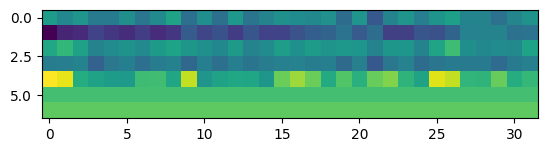

In [3]:
X_train, X_test, y_train, y_test, profs_test, tf_test = get_data(X, y)
print(X_train.shape, X_test.shape, tf_test.shape)
plt.imshow(X_train[0][0][:])
print(profs_test.sum())

[001,    27] loss train: 2.9236 | test: 0.1237
[002,    27] loss train: 2.7316 | test: 0.1184
[003,    27] loss train: 2.6508 | test: 0.1155
[004,    27] loss train: 2.5788 | test: 0.1139
[005,    27] loss train: 2.5387 | test: 0.1133
[006,    27] loss train: 2.5406 | test: 0.1119
[007,    27] loss train: 2.4994 | test: 0.1122
[008,    27] loss train: 2.4332 | test: 0.1099
[009,    27] loss train: 2.4351 | test: 0.1116
[010,    27] loss train: 2.3921 | test: 0.1072
000 mae_train: 1.15
000 profit M5 :   +0.0 ->    +0.0 --
000 profit M15:   +0.0 ->    +0.0 --
000 profit H1 : +653.2 ->  +832.6 OK
000 mae_test: 1.26
-------------------------------------------------
[         nan          nan 653.18048096]  ->  [         nan          nan 832.64135742]
mae_train: 1.15 mae_test: 1.26 ratio: 1.10
av. profit boost: 0.2747492947154515


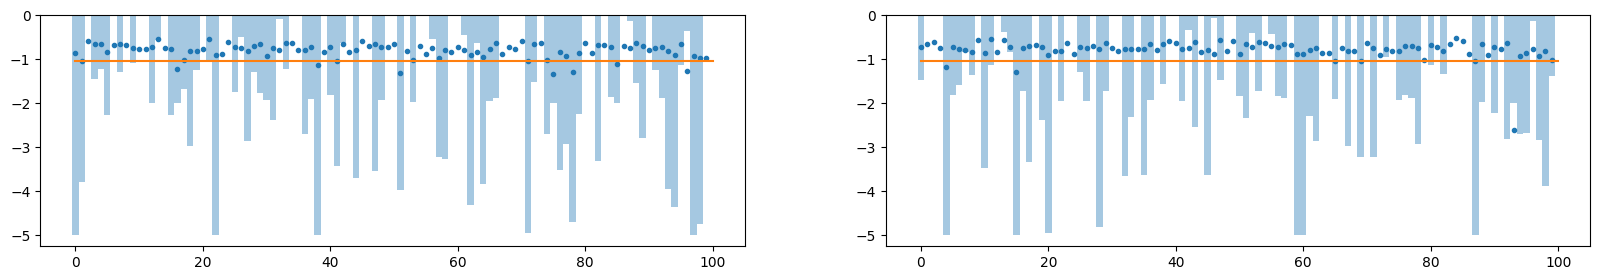

In [35]:
from sklearn.metrics import mean_absolute_error, f1_score
import torch
device = "mps"

nitrers = 1
test_split_size = 0.25
id2tf = {v:k for k, v in tfdict.items()}

pprofits, gprofits, metrics = np.zeros((3, nitrers)), np.zeros((3, nitrers)), np.zeros((2, nitrers))
for i in range(nitrers):
    np.random.seed(i)
    X_train, X_test, y_train, y_test, profs_test, tf_test = get_data(X, y, test_split_size)
    model = train(X_train, y_train, X_test, y_test, batch_size=256)
    model.eval()
    
    p_train = model(torch.tensor(X_train).float().to(device)).detach().cpu().numpy().squeeze()
    p_test = model(torch.tensor(X_test).float().to(device)).detach().cpu().numpy().squeeze()
    metrics[0, i] = mean_absolute_error(p_train, y_train)
    print(f"{i:03} mae_train: {metrics[0, i]:4.2f}")
    if test_split_size > 0:
        metrics[1, i] = mean_absolute_error(p_test, y_test)
        threshold = np.percentile(p_train, 5)
        for j in range(3):
            ids = tf_test == j
            pprofits[j, i] = (profs_test[ids]*(p_test[ids]>threshold)).sum()
            gprofits[j, i] = profs_test[ids].sum()
            print(f"{i:03} profit {id2tf[j]:3}:{gprofits[j, i]:+7.1f} -> {pprofits[j, i]:+7.1f} {'OK' if pprofits[j, i] > gprofits[j, i] else '--'}")
        print(f"{i:03} mae_test: {metrics[1, i]:4.2f}")
        
        pprofs_mean = pprofits.mean(axis=1, where=pprofits!=0)
        gprofs_mean = gprofits.mean(axis=1, where=gprofits!=0)
        f1_mean = metrics.mean(axis=1, where=metrics!=0)
        pprofs_mean_tot = np.nanmean(pprofs_mean)
        gprofs_mean_tot = np.nanmean(gprofs_mean)
        print("-------------------------------------------------")
        print(gprofs_mean, " -> ", pprofs_mean)
        print(f"mae_train: {f1_mean[0]:4.2f} mae_test: {f1_mean[1]:4.2f} ratio: {f1_mean[1]/f1_mean[0]:4.2f}")
        print(f"av. profit boost: {(pprofs_mean_tot - gprofs_mean_tot)/abs(gprofs_mean_tot)}")

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(p_train[:100], ".")
plt.bar(np.arange(100), y_train[:100], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])
if len(p_test):
    plt.subplot(1, 2, 2)
    plt.plot(p_test[:100], ".")
    plt.bar(np.arange(100), y_test[:100], width=[1]*100, alpha=0.4)
    # plt.bar(np.arange(100), profs_test[:100], width=[1]*100, alpha=0.2)
    plt.plot([0, 100], [threshold, threshold])
torch.save(model.state_dict(), "model.pth")

In [26]:
p_test[p_test<-1]

array([-1.014769 , -1.1845456, -1.0852048, ..., -1.5033214, -1.0727471,
       -1.1273975], dtype=float32)

In [36]:
threshold

-1.048260122537613

In [14]:
y_test.sum(), (p_test>threshold).sum(), p_test.shape[0], y_test.shape[0]

(-3383.0942, 2097, 2303, 2303)

In [7]:
import mplfinance as mpf

ticker = "BTCUSDT"
tf = "H1"
hist_pd, hist = DataParser(
    EasyDict(
        date_start="2008-01-01",
        period=tf,
        ticker=ticker,
        data_type="bitfinex"
        )).load()

for i in ids_test:
    pos = poslist[i]
    if pos.ticker == ticker:
        prediction = model.predict_proba([X[i, :-1]])[0][1]
        if prediction < threshold:
            print(pos.ticker, pos.open_date, prediction)
            d2 = pd.to_datetime(pos.close_date)
            d1 = pd.to_datetime(pos.open_date)
            d0 = d1 - pd.DateOffset(days=3)
            hist2plot = hist_pd.loc[d0:d2]
            fig = mpf.plot(hist2plot, 
                type='candle', 
                block=False)

FileNotFoundError: data/bitfinex/H1

In [ ]:
prediction

array([[0.49287947, 0.50712053]])